In [1]:
import pandas as pd
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
data_dst = 'data'
fig_dst = 'figures'
from tabulate import tabulate

In [2]:
portfolio = pd.read_json(os.path.join(data_dst, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(data_dst, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(data_dst, 'transcript.json'), orient='records', lines=True)

## Get to know the data

### portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
print(tabulate(portfolio, tablefmt='html', headers='keys', showindex=False))

`portfolio` contains 10 different offers, categorized into 3 types (BOGO, discount and informational). 

### profile 

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
print(tabulate(profile.head(), tablefmt='html', headers='keys', showindex=False))

`profile` contains information of each customer. Since there are notable NaNs in certain columns, let's take a closer look.

In [7]:
profile_nan = profile[profile.isnull().any(axis=1)]
profile_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
gender              0 non-null object
age                 2175 non-null int64
id                  2175 non-null object
became_member_on    2175 non-null int64
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [8]:
profile_nan['age'].unique()

array([118])

All these rows with NaNs have gender and income as NaN, and age of 118. As already mentioned in the data source, 118 is the encoded missing value for age. Therefore, imputation is required for gender, age and income. The median of numerical fields (age and income) is used, and another label ('U' for unknown) is applied for gender. Finally, since the three fields are either all missing or full, only one column 'profile_nan' is added as an indication of missing values. 

In [9]:
profile.loc[profile.isnull().any(axis=1), 'age'] = None
profile['profile_nan'] = 0
profile.loc[profile.isnull().any(axis=1), 'profile_nan'] = 1
profile['gender'].fillna('U', inplace=True)
profile['age'].fillna(profile['age'].median(), inplace=True)
profile['income'].fillna(profile['income'].median(), inplace=True)

In [10]:
profile.head()

,gender,age,id,became_member_on,income,profile_nan
0,U,55.0,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0
2,U,55.0,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0
4,U,55.0,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,1


In [ ]:
print(tabulate(profile.head(), tablefmt='html', headers='keys', showindex=False))

In [12]:
profile.to_csv(os.path.join(data_dst, 'profile_clean.csv'), index=False)

### transcript

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


`transcript` records all events during this 30-day simulation. Let's take a look at the transcript of a particular customer and all the unique events.

In [14]:
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [ ]:
print(tabulate(transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef'], tablefmt='html', headers='keys', showindex=False))

In [16]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

There are four types of events recorded in `transcript`, transactions and three types of offer activities. By looking at activities of one customer, the meaning behind each offer activity becomes clear.

* 'offer received' marks the time when Starbucks sends the offer to the customer, and the offer becomes effective instantly regardless whether the customer has viewed it or not. 
* 'offer viewed' marks the time when customer views the offer or becomes aware of it. Note that the customer can still view the offer even if he/she has already completed without knowing it, as long as the time is still within the offer's duration. 
* 'offer completed' marks the time when the customer makes qualified transaction meeting the requirement. The dict in the 'value' column has an additional key 'reward', which is associated with the offer id in `portfolio`.

To further explore offer activities, split `transcript` to transactions and offer activities, and extract out transaction amount and offer id from transactions and offer activities, respectively.

In [17]:
offer_log = transcript[transcript['event'].str.startswith('offer')]
offer_log.loc[:, 'offer'] = offer_log['value'].apply(lambda c: c['offer id'] if 'offer id' in c else c['offer_id'])
offer_log.drop(['value'], axis=1, inplace=True)
trans_log = transcript[transcript['event'] == 'transaction']
trans_log.loc[:, 'amount'] = trans_log['value'].apply(lambda c: c['amount'])
trans_log.drop(['value'], axis=1, inplace=True)

Take a look at offer activities based on offer type. 

In [18]:
offer_types = pd.merge(offer_log, portfolio[['id', 'offer_type']], left_on='offer', right_on='id')
offer_types.head()

,person,event,time,offer,id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo


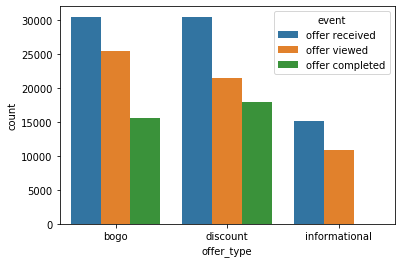

In [19]:
ax = sns.countplot(x='offer_type', hue='event', data=offer_types)
ax.figure.savefig(os.path.join(fig_dst, 'offer_event_count.png'), dpi=300)

It is noteworthy that informational offers do not have completion events, possibly because there is no reward to claim.

Based on the understanding of offer activities, here are the proposed **rules** for processing `transcript` to label responses: 

* A positive response requires both customer's awareness (viewed) and offer completion. The former must occur before the latter. 
* For informational offers, the response is determined from the number of transactions within the effective time window between viewed time and offer expiration. No transactions simply indicate a negative response. 

Use the 'offer received' event as the starting point for labeling. Explore more details about the offers sent. 

In [20]:
offer_receive = offer_log[offer_log['event'] == 'offer received']

In [21]:
offer_receive['time'].unique() / 24

array([ 0.,  7., 14., 17., 21., 24.])

During the 30-day simulation, Starbucks only sends out six waves of offers. The time interval between offer waves varies from three days to a week.

In [22]:
tmax = transcript.iloc[-1]['time']
tmax / 24

29.75

the final wave of offers arrives on the 24th day, leaving less than six days in `transcript`. Some offers have longer duration and the final response remains unknown if they are not completed by the final time mark in `transcript`. Those offers will be dropped during processing.

In [23]:
offer_receive.groupby(['person', 'offer']).count()['event'].value_counts()

1    51570
2    10523
3     1124
4       66
5        5
Name: event, dtype: int64

As a final remark, a unique customer-offer pair may have different responses since there are customers getting the same offer for more than once. Their responses may not necessarily remain the same. However, a model predicting customer-offer match should yield a unique output based on the input. To simplify the problem, a customer-offer pair is labeled as positive as long as the customer responses to the offer positively for once. 

## Transform data

Process `transcript` to label the response in `offer_receive` with one particular customer-offer pair as the unit, and loop it through all appearing customers and offers sent to each one of them. Concerns regarding business logics are explained in the comments. 

In [24]:
from collections import deque

offer_receive['positive_response'] = 0

def label_response(person, offer):
    log = offer_log[(offer_log['person'] == person) & (offer_log['offer'] == offer)]
    offer_data = portfolio[portfolio['id'] == offer].squeeze()
    offer_type = offer_data['offer_type']
    duration = offer_data['duration'] * 24
    
    received = deque([])
    
    for _, row in log.iterrows():
        t = row['time']
        if row['event'] == 'offer received':
            received.append([t, t + duration, None])  # offer represented as [t_receive, t_expire, t_viewed] 
        elif row['event'] == 'offer completed':  # bogo and discount completed
            t_receive, _, t_viewed = received.popleft()
            if t_viewed is not None:
                offer_receive.loc[(offer_receive['person'] == person) & (offer_receive['offer'] == offer) & (offer_receive['time'] == t_receive),
                                  'positive_response'] = 1
        elif row['event'] == 'offer viewed' and received:
            # mark newer informational offer as viewed while older other offers
            # since offer chasers will likely to complete the older one first
            loop = range(len(received) - 1, -1, -1) if offer_type == 'informational' else range(len(received))
            for i in loop:
                if received[i][2] is None:
                    break
            received[i][2] = t
        # pop out expired offers 
        # and confirm response for informational offers
        while received and received[0][1] < t:  
            t_receive, t_expire, t_viewed = received.popleft()
            if offer_type == 'informational' and t_viewed is not None:
                transactions = trans_log[(trans_log['person'] == person) & (trans_log['time'].between(t_viewed, t_expire))]
                if len(transactions) > 0:  
                    offer_receive.loc[(offer_receive['person'] == person) & (offer_receive['offer'] == offer) & (offer_receive['time'] == t_receive),
                                      'positive_response'] = 1
    # handle not completed late offers
    while received:
        t_receive, t_expire, _ = received.popleft()
        if t_expire > tmax:
            offer_receive.loc[(offer_receive['person'] == person) & (offer_receive['offer'] == offer) & (offer_receive['time'] == t_receive),
                              'positive_response'] = None

In [25]:
from tqdm import tqdm
import time

for person in tqdm(offer_receive['person'].unique()):
    offers = offer_receive[offer_receive['person'] == person]['offer'].unique()
    for offer in offers:
        label_response(person, offer)
    time.sleep(0.001)

100%|██████████| 16994/16994 [33:47<00:00,  8.38it/s]


Group `offer_receive` by 'person' and 'offer' using logic OR, and drop irrelevant columns.

In [26]:
response = offer_receive.groupby(['person', 'offer']).any().reset_index()
response.drop(columns=['event', 'time'], inplace=True)
response.head()

,person,offer,positive_response
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,False
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,False
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False


In [ ]:
print(tabulate(response.head(), tablefmt='html', headers='keys', showindex=False))

In [28]:
response.to_csv(os.path.join(data_dst, 'response.csv'), index=False)

## Further process data
Encode columns not suitable as inputs for a model, and drop the original columns. 

### portfolio

In [29]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The 'channels' column contains the four media where the offer is sent. Use one-hot encoding for each one of them. 

In [30]:
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio['channel_%s' % channel] = portfolio['channels'].apply(lambda c: int(channel in c))
portfolio

,reward,channels,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


Looks like all offers are sent via email, so the 'channel_email' column should also be dropped.

In [31]:
portfolio.drop(columns=['channels', 'channel_email'], inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,channel_web,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0


Use one-hot encoding for 'offer_type' column since there are only three different types of offers. 

In [32]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type']).add_prefix('type_')], axis=1)
portfolio.drop(columns=['offer_type'], inplace=True)
portfolio

,reward,difficulty,duration,id,channel_web,channel_mobile,channel_social,type_bogo,type_discount,type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,1,0


`portfolio` is ready to be joined into `response`.

In [33]:
portfolio.to_csv(os.path.join(data_dst, 'portfolio_encoded.csv'), index=False)

### profile

In [34]:
profile.head()

,gender,age,id,became_member_on,income,profile_nan
0,U,55.0,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0
2,U,55.0,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0
4,U,55.0,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,1


Transform the 'became_member_on' column to datetime.

In [35]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_on'].max()

Timestamp('2018-07-26 00:00:00')

The most recent member signed up on 2018-7-26. Since there is no datetime information available in the `transcript`, convert this column to the total time (in day) in membership as of a later date (2018-8-1). 

In [36]:
profile['days_as_member'] = (pd.to_datetime('2018-08-01') - profile['became_member_on']).dt.days
profile.drop(columns=['became_member_on'], inplace=True)
profile.head()

,gender,age,id,income,profile_nan,days_as_member
0,U,55.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1,535
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,382
2,U,55.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,1,20
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,449
4,U,55.0,a03223e636434f42ac4c3df47e8bac43,64000.0,1,362


Use one-hot encoding for 'gender' column since there are only four different labels. 

In [37]:
profile = pd.concat([profile, pd.get_dummies(profile['gender']).add_prefix('gender_')], axis=1)
profile.drop(columns=['gender'], inplace=True)
profile.head()

,age,id,income,profile_nan,days_as_member,gender_F,gender_M,gender_O,gender_U
0,55.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1,535,0,0,0,1
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,382,1,0,0,0
2,55.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,1,20,0,0,0,1
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,449,1,0,0,0
4,55.0,a03223e636434f42ac4c3df47e8bac43,64000.0,1,362,0,0,0,1


`profile` is ready to be joined into `response`.  

In [38]:
profile.to_csv(os.path.join(data_dst, 'profile_encoded.csv'), index=False)

## Generate data for modeling

Join `portfolio` and `profile` with `response`. 

In [39]:
all_data = pd.merge(response, portfolio, left_on='offer', right_on='id')
all_data = pd.merge(all_data, profile, left_on='person', right_on='id')
all_data.drop(columns=['person', 'offer', 'id_x', 'id_y'], inplace=True)
all_data.head()

,positive_response,reward,difficulty,duration,channel_web,channel_mobile,channel_social,type_bogo,type_discount,type_informational,age,income,profile_nan,days_as_member,gender_F,gender_M,gender_O,gender_U
0,False,2,10,7,1,1,0,0,1,0,33.0,72000.0,0,467,0,1,0,0
1,False,0,0,4,1,1,0,0,0,1,33.0,72000.0,0,467,0,1,0,0
2,False,0,0,3,0,1,1,0,0,1,33.0,72000.0,0,467,0,1,0,0
3,False,5,5,5,1,1,1,1,0,0,33.0,72000.0,0,467,0,1,0,0
4,False,2,10,10,1,1,1,0,1,0,33.0,72000.0,0,467,0,1,0,0


In [40]:
all_data.to_csv(os.path.join(data_dst, 'all_data.csv'), index=False)

## Split training and test data

In [41]:
from sklearn.model_selection import train_test_split

y = all_data['positive_response'].astype(int)
X = all_data.drop(columns=['positive_response'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=41)

In [42]:
train_X.to_csv(os.path.join(data_dst, 'train_X.csv'), index=False)
train_y.to_csv(os.path.join(data_dst, 'train_y.csv'), index=False)
test_X.to_csv(os.path.join(data_dst, 'test_X.csv'), index=False)
test_y.to_csv(os.path.join(data_dst, 'test_y.csv'), index=False)